NOTE: The DATASET IS REINDEXED FOR BEST RESULTS ACHIEVED 50% 

Import all relative and required libraries as follows 

In [13]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
import preprocessing

import data, identify relevant parts of it, identify parameteres as step_size

In [14]:
step_size = 1
# FOR REPRODUCIBILITY
np.random.seed(7)

# IMPORTING DATASET 
dataset = pd.read_csv('prova.csv', usecols=[1,2,3,4,5,6,7])
dataset = dataset.reindex(index = dataset.index[::-1])

# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

# TAKING DIFFERENT INDICATORS FOR PREDICTION
#OHLC_avg = dataset.mean(axis = 1)
OHLC_avg =  dataset[['OHLC_avg']]
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]
open_val = dataset[['Open']]
classes =  dataset[['Label']]

plot data

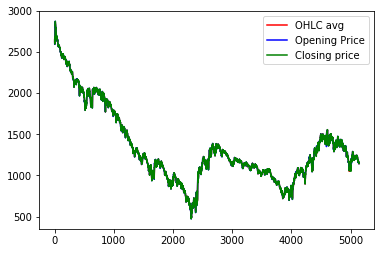

In [15]:
# PLOTTING ALL INDICATORS IN ONE PLOT
plt.plot(obs, OHLC_avg, 'r', label = 'OHLC avg')
plt.plot(obs, open_val, 'b', label = 'Opening Price')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()

Prepare data : reshape and scale down 

In [16]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) 
close_val = np.reshape(close_val.values, (len(close_val),1))
open_val = np.reshape(open_val.values, (len(open_val),1)) 
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)
close_val = scaler.fit_transform(close_val)
open_val = scaler.fit_transform(open_val)
classes = np.reshape(classes.values, len(close_val))

Split data : 75% for training 25% for testing
change it to time series data
and reshape it

In [17]:
## TRAIN-TEST SPLIT
train_OHLCs = int(len(OHLC_avg) * 0.75)
test_OHLCs = len(OHLC_avg) - train_OHLCs
train_classes , test_classes  = classes[0:train_OHLCs] ,classes[train_OHLCs:len(OHLC_avg)] 
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLCs,:], OHLC_avg[train_OHLCs:len(OHLC_avg),:]
train_close, test_close = close_val[0:train_OHLCs,:], close_val[train_OHLCs:len(OHLC_avg),:]
train_open, test_open = open_val[0:train_OHLCs,:], open_val[train_OHLCs:len(OHLC_avg),:]

# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX_OHLC, trainY_OHLC = preprocessing.new_dataset(train_OHLC, step_size)
testX_OHLC, testY_OHLC = preprocessing.new_dataset(test_OHLC, step_size)

trainX_close, trainY_close = preprocessing.new_dataset(train_close, step_size)
testX_close, testY_close = preprocessing.new_dataset(test_close, step_size)

trainX_open, trainY_open = preprocessing.new_dataset(train_open, step_size)
testX_open, testY_open = preprocessing.new_dataset(test_open, step_size)

# RESHAPING TRAIN AND TEST DATA
trainX_OHLC = np.reshape(trainX_OHLC, (trainX_OHLC.shape[0], 1, trainX_OHLC.shape[1]))
testX_OHLC = np.reshape(testX_OHLC, (testX_OHLC.shape[0], 1, testX_OHLC.shape[1]))

trainX_close = np.reshape(trainX_close, (trainX_close.shape[0], 1, trainX_close.shape[1]))
testX_close = np.reshape(testX_close, (testX_close.shape[0], 1, testX_close.shape[1]))

trainX_open = np.reshape(trainX_open, (trainX_open.shape[0], 1, trainX_open.shape[1]))
testX_open = np.reshape(testX_open, (testX_open.shape[0], 1, testX_open.shape[1]))
#


set the network model, compile it and fit it to training data

In [18]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(64, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(32))
model.add(Dense(1))
model.add(Activation('linear'))

# MODEL COMPILING AND TRAINING
model.compile(loss='mse', optimizer='adagrad') # Try SGD, adam, adagrad and compare!!!
model.fit(trainX_close, trainY_close, epochs=4, batch_size=1, verbose=2)
#model.fit(trainX_OHLC, trainY_OHLC, epochs=5, batch_size=1, verbose=2)
#model.fit(trainX_OHLC, trainY_OHLC, epochs=5, batch_size=1, verbose=2)

Epoch 1/4
 - 13s - loss: 9.8594e-04
Epoch 2/4
 - 13s - loss: 9.1727e-05
Epoch 3/4
 - 13s - loss: 6.5498e-05
Epoch 4/4
 - 12s - loss: 5.2990e-05


Predict future values and conclude classes, then compute error by comparing to True classes

In [19]:
# PREDICTION
####
trainPredict = model.predict(trainX_close)
testPredict = model.predict(testX_close)
testPredict_open = model.predict(testX_open)

#classify 
classes_pre =preprocessing.classify(testPredict,testPredict_open)
classes_pre = np.asarray(classes_pre)
error_classes = preprocessing.error_classes(classes[len(classes_pre)+1:],classes_pre)
#classes_s = classes_s.reindex(index = classes_s.index[::-1])
print('error in predicting classes : ',error_classes)

error in predicting classes :  49.8439937598


In [20]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
###
trainY_close = scaler.inverse_transform([trainY_close])
testY_close = scaler.inverse_transform([testY_close])

#trainY_OHLC = scaler.inverse_transform([trainY_OHLC])
#testY_OHLC = scaler.inverse_transform([testY_OHLC])
#
#trainY_open = scaler.inverse_transform([trainY_open])
#testY_open = scaler.inverse_transform([testY_open])

Train RMSE: 16.41
Test RMSE: 17.33


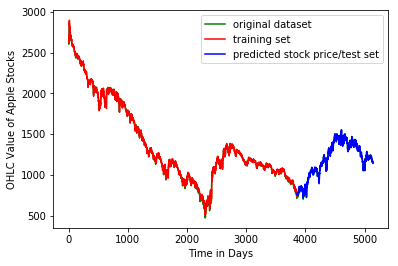

Last Day Value: 1146.8218994140625
Next Day Value: 1157.7496337890625


In [21]:

# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY_close[0], trainPredict[:,0]))
#trainScore = math.sqrt(mean_squared_error(trainY_OHLC[0], trainPredict[:,0]))
#trainScore = math.sqrt(mean_squared_error(trainY_open[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY_close[0], testPredict[:,0]))
#testScore = math.sqrt(mean_squared_error(testY_OHLC[0], testPredict[:,0]))
#testScore = math.sqrt(mean_squared_error(testY_open[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(close_val)
#trainPredictPlot = np.empty_like(OHLC_avg)
#trainPredictPlot = np.empty_like(open_val)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict


# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(close_val)
#testPredictPlot = np.empty_like(OHLC_avg)
#testPredictPlot = np.empty_like(open_val)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(close_val)-1, :] = testPredict
#testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict
#testPredictPlot[len(trainPredict)+(step_size*2)+1:len(open_val)-1, :] = testPredict



# DE-NORMALIZING MAIN DATASET 
close_val = scaler.inverse_transform(close_val)
OHLC_avg = scaler.inverse_transform(OHLC_avg)
#open_val = scaler.inverse_transform(open_val)

# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of Apple Stocks')
plt.show()


# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))
# print np.append(last_val, next_val)
